Time Series Classification 

 Feature Creation/Extraction



 The dataset contains 7 folders that represent seven types of activities. In
each folder, there are multiple files each of which represents an instant of a human
performing an activity.1 Each file containis 6 time series collected from activities
of the same person, which are called avg rss12, var rss12, avg rss13, var rss13,
vg rss23, and ar rss23. There are 88 instances in the dataset, each of which con-
tains 6 time series and each time series has 480 consecutive values.

In [73]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

# data explanation
time_series_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
all_features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
time_series_features = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quartile', '3rd quartile' ]
feature_dict = {'50%': 'median', '25%': '1st quart', '75%': '3rd quart', 'std': 'standard deviation', 'min': 'min', 'max': 'max', 'mean': 'mean'}
classes_dict = {'bending1': 0, 'bending2': 1, 'cycling': 2, 'lying': 3, 'sitting': 4, 'standing': 5, 'walking': 6}
rev_classes_dict = {0: 'bending1', 1: 'bending2', 2: 'cycling', 3: 'lying', 4: 'sitting', 5: 'standing', 6: 'walking'}
binary_class_dict = {1: 'bending', 0: 'non-bending'}


#extractcing data
files = {}


for folder in os.listdir(FILEPATH):
    if folder == '.DS_Store': continue
    if 'pdf' in folder:
            continue
    for file in os.listdir(FILEPATH + folder):
        key = FILEPATH + folder + '/' + file
        files[key] = pd.read_csv(key, skiprows = 4, usecols = [0, 1, 2, 3, 4, 5, 6])
        del files[key][files[key].columns[0]]

Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,
2, and 3 in other folders as test data and other datasets as train data.

In [74]:
data_train_mapping = {}
test_data_map = {}
for folder in os.listdir(FILEPATH):
    if folder == '.DS_Store': continue
    for file in os.listdir(FILEPATH + folder):
        file_name = FILEPATH + folder + '/' + file
        if (folder == 'bending1' or folder == 'bending2'):
            if file == 'dataset1.csv' or file == 'dataset2.csv':
                test_data_map[file_name] = files[file_name]
            else:
                data_train_mapping[file_name] = files[file_name]
        else:
            if file == 'dataset1.csv' or file == 'dataset2.csv' or file == 'dataset3.csv':
                test_data_map[file_name] = files[file_name]
            else:
                data_train_mapping[file_name] = files[file_name]

print("train data nums:")
print(len(data_train_mapping))
print("------------------------")
print("test data nums")
print(len(test_data_map))

train data nums:
69
------------------------
test data nums
19


In [75]:
def train_test_split(file_path = FILEPATH):
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    
    folders = os.listdir(file_path)

    for folder in folders:
        if folder == '.DS_Store': continue
        if 'pdf' in folder:
            continue
        path = os.path.join(file_path, folder)
        files = os.listdir(path)

        if folder == 'bending1' or folder == 'bending2':
            for file in files:
                data = pd.read_csv(os.path.join(file_path, folder, file), skiprows=4, usecols=range(7))
                if file == 'dataset1.csv' or file == 'dataset2.csv':
                    df_test = pd.concat([df_test, data], ignore_index = True)
                else:
                    df_train = pd.concat([df_train, data], ignore_index = True)
                
        else:
            for file in files:
                data = pd.read_csv(os.path.join(file_path, folder, file), skiprows=4 ,usecols=range(7))
                if file == 'dataset1.csv' or file == 'dataset2.csv' or file == 'dataset3.csv':
                    df_test = pd.concat([df_test, data], ignore_index = True)
                else:
                    df_train = pd.concat([df_train, data], ignore_index = True)
    
    print('Train shape: ', df_train.shape)
    print('Test shape: ', df_test.shape)
    return df_train, df_test

df_train, df_test = train_test_split()
df_train.head()

Train shape:  (33119, 7)
Test shape:  (9120, 7)


,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,42.00,0.00,18.50,0.50,12.00,0.00
1,250,42.00,0.00,18.00,0.00,11.33,0.94
2,500,42.75,0.43,16.75,1.79,18.25,0.43
3,750,42.50,0.50,16.75,0.83,19.00,1.22
4,1000,43.00,0.82,16.25,0.83,18.00,0.00


C) Feature Extraction

In [76]:
columns = []
def fetch_sensor_data(file_path, columns):
    
    folders = os.listdir(file_path)
    data = []
    
    for folder in folders:
        if folder == '.DS_Store': continue
        if 'pdf' in folder:
            continue
        path = os.path.join(file_path, folder)
        files = os.listdir(path)
        
        for file in files:
            data.append(pd.read_csv(os.path.join(path, file), skiprows=4 ,usecols=range(7)))

    df = pd.DataFrame(columns = columns)
    for d in data:
        summary = d.describe()
        row = []
        for i in range(1,7):
            row.append(summary.iloc[3,i])
            row.append(summary.iloc[7,i])
            row.append(summary.iloc[1,i])
            row.append(summary.iloc[5,i])
            row.append(summary.iloc[2,i])
            row.append(summary.iloc[4,i])
            row.append(summary.iloc[6,i])
        df = pd.concat([df, pd.DataFrame([row], columns=columns)], ignore_index=True)

    df.index + 1  
    return df

for i in range (1,7):
    columns.append([a+str(i) for a in time_series_features])
columns = [item for sublist in columns for item in sublist]



In [77]:
df = fetch_sensor_data(FILEPATH, columns)
df

,min1,max1,mean1,median1,standard deviation1,1st quartile1,3rd quartile1,min2,max2,mean2,...,standard deviation5,1st quartile5,3rd quartile5,min6,max6,mean6,median6,standard deviation6,1st quartile6,3rd quartile6
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.8300
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,33.00,47.75,42.179812,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,37.25,45.00,40.624792,40.50,1.476967,39.2500,42.00,0.0,1.30,0.358604,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,3.120057,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600
84,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000
85,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,3.617702,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175
86,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,2.851673,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300


In [78]:
df.describe().loc[['std']].T

,std
min1,9.569975
max1,4.394362
mean1,5.335718
median1,5.440054
standard deviation1,1.772153
1st quartile1,6.153590
3rd quartile1,5.138925
min2,0.000000
max2,5.062729
mean2,1.574164


In [79]:
confidence_intervals = pd.DataFrame()
for i in range(len(df.columns)):
    sample_data = (df.iloc[:, i],)
    res = bootstrap(sample_data, np.std, confidence_level = 0.9, random_state = 1, method = 'percentile')
    temp = pd.DataFrame({'Feature': df.columns[i], 'Lower Bound': res.confidence_interval.low, 'Upper Bound': res.confidence_interval.high}, index=[i+1])
    confidence_intervals = pd.concat([confidence_intervals, temp], ignore_index = True)
confidence_intervals

,Feature,Lower Bound,Upper Bound
0,min1,8.217348,10.704231
1,max1,3.306005,5.269063
2,mean1,4.675214,5.837115
3,median1,4.760294,5.964649
4,standard deviation1,1.562763,1.935570
5,1st quartile1,5.542312,6.603819
6,3rd quartile1,4.308947,5.806972
7,min2,0.000000,0.000000
8,max2,4.595134,5.377385
9,mean2,1.393100,1.698068


Judgement to select the three most important time-domain features
(one option may be min, mean, and max).

2. Time Series Classification Part 2: Binary and Multiclass Classification

use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. 

In [80]:
def key_to_class_fn(key, is_binary):   
    key = key.split('/')[3]
    
    if is_binary:
        return 1 if 'bending' in key else 0
    else:
        return classes_dict[key] 

In [81]:
def feature_extraction_fn(chosen_labels, chosen_features, split):
    ans = []
    for split_no in range(split):
        for time_series_col in chosen_labels:
            for feature in chosen_features:
                ans += [time_series_col + '_' + feature_dict[feature] + str(split_no + 1)]
    ans += ['type']
    return ans

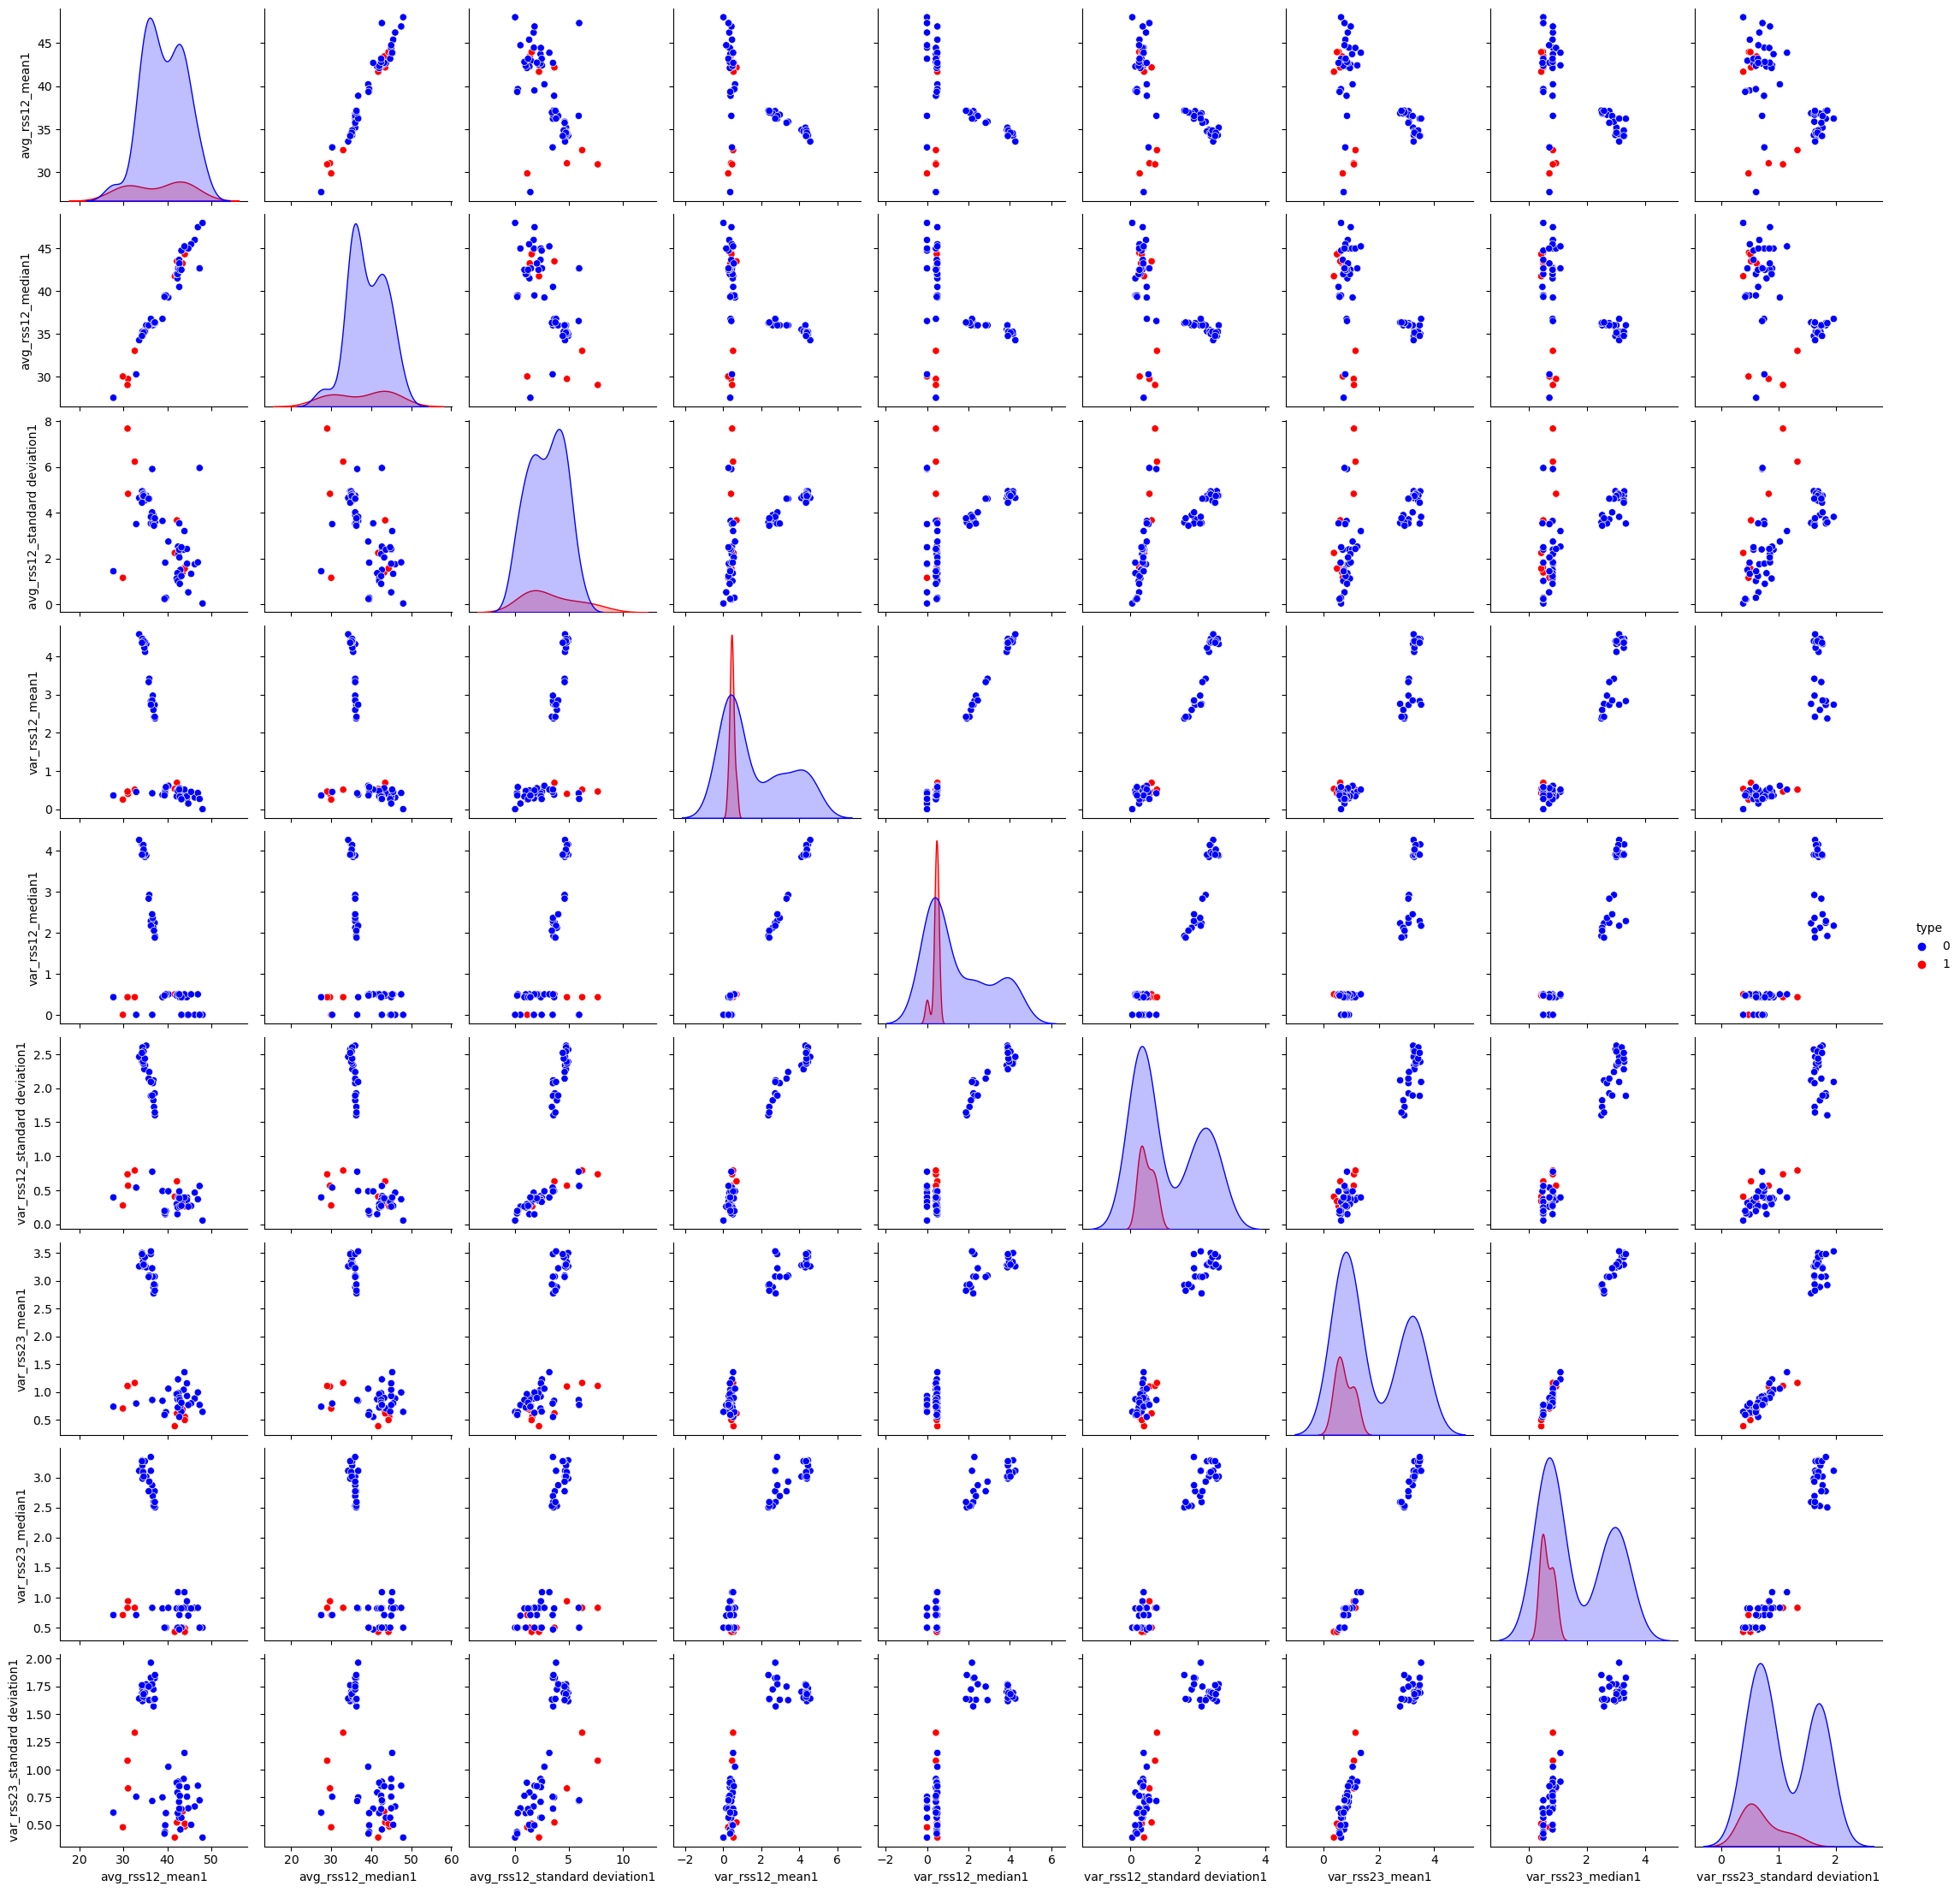

In [82]:
def sensor_data_retrieval_fn(data_train_mapping, split, headers, time_series, selected_features, is_binary=True):

    train_df = []
    for k, v in data_train_mapping.items():
        splits = np.array_split(v, split)
        temp = []
        for s in splits:
            stat = s.describe()
            for series in time_series:
                for feature in selected_features:
                    temp.append(stat[series][feature])

        temp.append(key_to_class_fn(k, is_binary))
        train_df.append(temp)
        
    train_df = pd.DataFrame(train_df, columns = headers)
    return train_df

chosen_labels = ['avg_rss12', 'var_rss12', 'var_rss23']
selected_features = ['mean', '50%', 'std']
headers = feature_extraction_fn(chosen_labels, selected_features, 1)
train_data_df = sensor_data_retrieval_fn(data_train_mapping, 1, headers, chosen_labels, selected_features)    
sns.pairplot(data = train_data_df, hue = 'type', palette = {1: 'red', 0: 'blue'})

#### Observation:
* In the initial oberservation, we don't notice much of a difference between both the plots. 

iii) Time Series Segment

In [83]:
def class_oversampling_fn(train_df):
    
    total0 = train_df.loc[train_df['type'] == 0].shape[0]
    total1 = train_df.loc[train_df['type'] == 1].shape[0]
    minor_label, major_label = (1, 0) if total0 > total1 else (0, 1)
        
    minor_ds = train_df[train_df['type'] == minor_label]
    major_ds = train_df[train_df['type'] == major_label]
    
    minor_ds = resample(minor_ds, replace = True, random_state = 60, n_samples = max(total0, total1))
    train_df = pd.concat([major_ds, minor_ds])
    return train_df

In [84]:
def logistic_regression_fn(data_train_mapping, test_data_map, split, cv_fold, time_series = time_series_columns, features = all_features, oversampling = False):

    # get features and data
    headers = feature_extraction_fn(time_series, features, split)
    train_df = sensor_data_retrieval_fn(data_train_mapping, split, headers, time_series, features)    
    
    # oversampling to prevent imbalance
    if oversampling: 
        train_df = class_oversampling_fn(train_df)
    
    # spliting data to train X and label Y
    trainX = train_df.iloc[:, :-1]
    trainY = train_df.iloc[:, -1]

    #  main model
    validator = StratifiedKFold(n_splits = cv_fold, shuffle = True, random_state = 69)
    model = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 100)
    selector = RFECV(estimator = model, cv = validator, scoring = 'accuracy')
    selector.fit(trainX, trainY)
    
    test_accuracy = selector.cv_results_['mean_test_score'].max()
    
    return model, selector, round(test_accuracy, 5), round(1 - test_accuracy, 5)

In [85]:
selected_features = ['mean', '50%', 'std']
cv_fold = 5
split_range = 20
LR_result = {'Split': [], 'No. of Features': [], 'Test Score': [], 'Test Error': []}
for split in range(1, split_range + 1):
    model, selector, score, error = logistic_regression_fn(data_train_mapping, test_data_map, split, cv_fold, features = selected_features)
    LR_result['Split'].append(split)
    LR_result['No. of Features'].append(selector.n_features_)
    LR_result['Test Score'].append(score)
    LR_result['Test Error'].append(error)

LR_result = pd.DataFrame(LR_result)
LR_result

,Split,No. of Features,Test Score,Test Error
0,1,11,0.95714,0.04286
1,2,35,0.94286,0.05714
2,3,4,0.95714,0.04286
3,4,3,0.97143,0.02857
4,5,2,0.97143,0.02857
5,6,4,0.97143,0.02857
6,7,8,0.98571,0.01429
7,8,3,0.97143,0.02857
8,9,57,0.97143,0.02857
9,10,92,0.98571,0.01429


Confusion Matrix

In [86]:
def selected_features_from_logistic_regression(features, selector):
    selected_features = []
    for i, feature in enumerate(features):
        if selector.support_[i]:
            selected_features.append(feature)
    return selected_features

In [87]:
selected_features = ['mean', '50%', 'std']

best_idx = LR_result['Test Score'].argmax()
print("Best pair: ({}, {}) \n".format(LR_result['Split'][best_idx], LR_result['No. of Features'][best_idx]))

split = LR_result['Test Score'].argmax() + 1
cv_fold = 5
headers = feature_extraction_fn(time_series_columns, selected_features, split)
model_lr, selector, score, error = logistic_regression_fn(data_train_mapping, test_data_map, split, cv_fold, features = selected_features)

RFE_selected_features = selected_features_from_logistic_regression(headers[:-1], selector)
print("RFE selected features: ", RFE_selected_features)

Best pair: (7, 8) 

RFE selected features:  ['avg_rss23_mean1', 'avg_rss13_mean2', 'avg_rss23_mean2', 'avg_rss23_median2', 'var_rss23_mean3', 'avg_rss12_mean5', 'avg_rss12_median5', 'var_rss13_mean5']


In [88]:
headers = feature_extraction_fn(time_series_columns, selected_features, split)
train_df = sensor_data_retrieval_fn(data_train_mapping, split, headers, time_series_columns, selected_features)  
trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
df_temp = trainX.loc[:, RFE_selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype = float))
model = sm.Logit(trainY.to_numpy(dtype = float), const_val)
summary = model.fit(method = 'bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       60
Method:                           MLE   Df Model:                            8
Date:                Mon, 10 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        23:37:38   Log-Likelihood:            -1.6375e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 8.882e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6875   1.24e+07  -5.5

Accuracy: 1.0
Confusion Matrix
[[60  0]
 [ 0  9]]


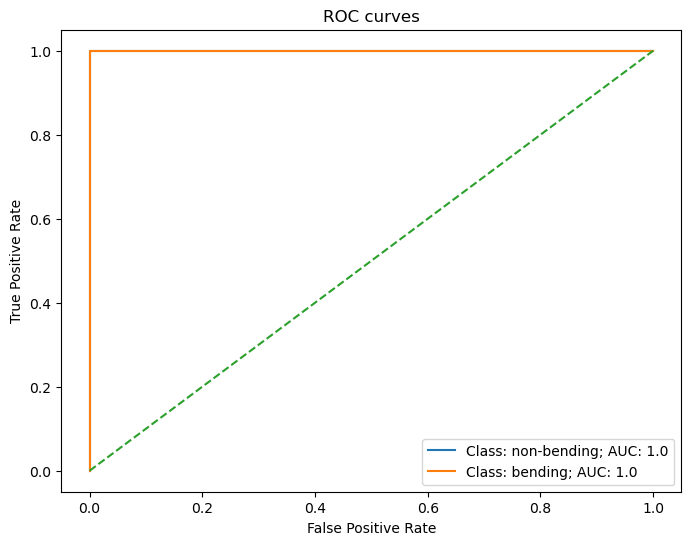

In [89]:
def roc_visualization_fn(true_y, pred_predicted_probs, model):
    
    _, axes = plt.subplots(figsize = (8, 6))
    axes.set_title("ROC curves")
    for i, class_ in enumerate(model.classes_):
        predicted_labels = pred_predicted_probs[:, i]
        fpr, tpr, thresholds = roc_curve(true_y, predicted_labels, pos_label = class_)
        roc_auc = auc(fpr, tpr)
        if (len(model.classes_) == 2):
            axes.plot(fpr, tpr, label = "Class: {}; AUC: {}".format(binary_class_dict[class_], round(roc_auc, 4)))
        else: 
            axes.plot(fpr, tpr, label = "Class: {}; AUC: {}".format(rev_classes_dict[class_], round(roc_auc, 4)))
    
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

def conf_mat_v_fn(model, trainX, trainY, selected_features, test_data = False):
    
    if not test_data:
        model.fit(trainX.loc[:, selected_features], trainY.to_numpy(dtype = "int"))
        
    pred_y = model.predict(trainX.loc[:, selected_features])
    pred_predicted_probs = model.predict_proba(trainX.loc[:, selected_features])
    pred_y = pred_y.round()
    true_y = trainY.to_numpy(dtype = float)
    t_score = model.score(trainX.loc[:, selected_features], trainY.to_numpy(dtype = "int"))
    print("Accuracy: {}".format(t_score))
    print("Confusion Matrix")
    print(confusion_matrix(true_y, pred_y))
    roc_visualization_fn(true_y, pred_predicted_probs, model)

conf_mat_v_fn(model_lr, trainX, trainY, RFE_selected_features)

v) Test Classifier

Accuracy: 1.0
Confusion Matrix
[[15  0]
 [ 0  4]]


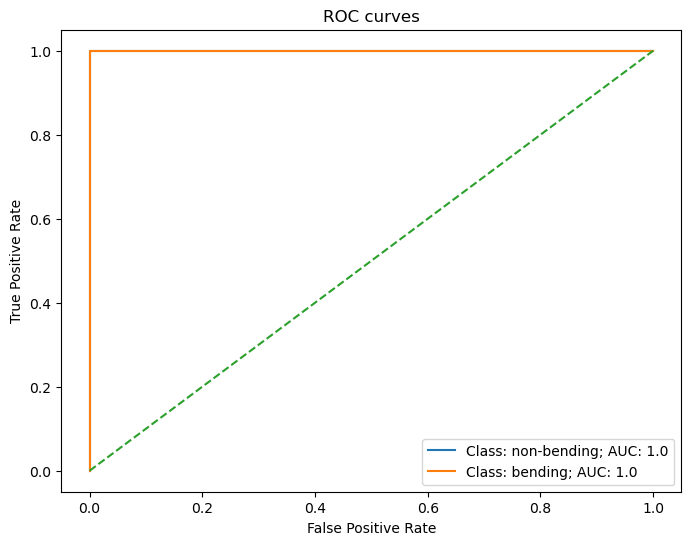

In [90]:
idx = LR_result['Test Score'].argmax()
split = idx + 1
headers = feature_extraction_fn(time_series_columns, selected_features, split)
test_df = sensor_data_retrieval_fn(test_data_map, split, headers, time_series_columns, selected_features)  
testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
test_df

conf_mat_v_fn(model_lr, testX, testY, RFE_selected_features, test_data = True)

In [91]:
selected_features = ['mean', '50%', 'std']
cv_fold = 5
split_range = 20
LR_Oversampling_result = {'Split': [], 'No. of Features': [], 'Test Score': [], 'Test Error': []}
for split in range(1, split_range + 1):
    model, selector, score, error = logistic_regression_fn(data_train_mapping, test_data_map, split, cv_fold, oversampling = True, features = selected_features)
    LR_Oversampling_result['Split'].append(split)
    LR_Oversampling_result['No. of Features'].append(selector.n_features_)
    LR_Oversampling_result['Test Score'].append(score)
    LR_Oversampling_result['Test Error'].append(error)

LR_Oversampling_result = pd.DataFrame(LR_Oversampling_result)
LR_Oversampling_result

,Split,No. of Features,Test Score,Test Error
0,1,11,0.97500,0.02500
1,2,14,0.97500,0.02500
2,3,6,0.98333,0.01667
3,4,3,0.98333,0.01667
4,5,6,0.98333,0.01667
5,6,2,0.99167,0.00833
6,7,6,0.98333,0.01667
7,8,10,0.98333,0.01667
8,9,3,1.00000,0.00000
9,10,5,0.99167,0.00833


In [92]:
selected_features = ['mean', '50%', 'std']

best_idx = LR_Oversampling_result['Test Score'].argmax()
print("Best pair: ({}, {}) \n".format(LR_Oversampling_result['Split'][best_idx], LR_Oversampling_result['No. of Features'][best_idx]))

split = LR_Oversampling_result['Test Score'].argmax() + 1
cv_fold = 5
headers = feature_extraction_fn(time_series_columns, selected_features, split)
model_oversampling_lr, selector, score, error = logistic_regression_fn(data_train_mapping, test_data_map, split, cv_fold, oversampling = True, features = selected_features)

RFE_selected_features = selected_features_from_logistic_regression(headers[:-1], selector)
print("RFE selected features: ", RFE_selected_features)

Best pair: (9, 3) 

RFE selected features:  ['avg_rss23_median2', 'avg_rss23_mean3', 'avg_rss12_mean6']


ROC Curve for train data

Accuracy: 1.0
Confusion Matrix
[[60  0]
 [ 0 60]]


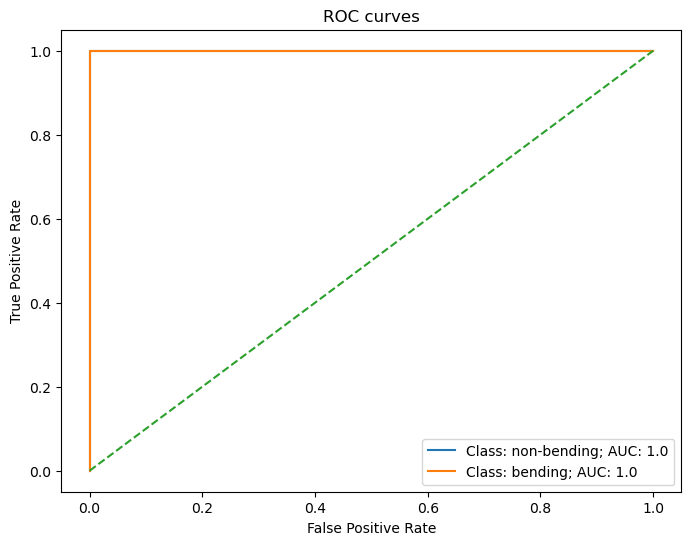

ROC Curve for test data

Accuracy: 1.0
Confusion Matrix
[[15  0]
 [ 0  4]]


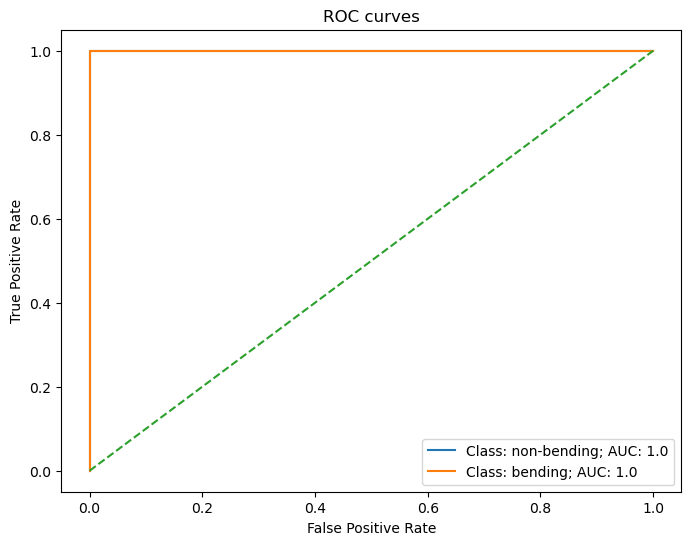

In [93]:
headers = feature_extraction_fn(time_series_columns, selected_features, split)
train_df = sensor_data_retrieval_fn(data_train_mapping, split, headers, time_series_columns, selected_features)  
train_df = class_oversampling_fn(train_df)
trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
print("ROC Curve for train data\n")
conf_mat_v_fn(model_oversampling_lr, trainX, trainY, RFE_selected_features)
print("ROC Curve for test data\n")
conf_mat_v_fn(model_oversampling_lr, testX, testY, RFE_selected_features)

Binary Classification Using L1-penalized logistic regression


i.e. instead of using p-
values for variable selection, use L1 regularization. Note that in this problem,

you have to cross-validate for both l, the number of time series into which you
break each of your instances, and λ, the weight of L1 penalty in your logistic
regression objective function (or C, the budget). Packages usually perform
cross-validation for λ automatically.

In [94]:
def get_index_best_c(model, find_C_in_dict):
    for i, c in enumerate(model.Cs_):
        if (c == find_C_in_dict): 
            return i

def logistic_regression_classification(data_train_mapping, test_data_map, split, time_series = time_series_columns, features = all_features, 
                         cv_fold = None, is_plot_roc = False,
                         is_binary = False, is_gaussian = False, is_multinomial_prior = False):
    
    headers = feature_extraction_fn(time_series_columns, features, split)
    train_df = sensor_data_retrieval_fn(data_train_mapping, split, headers, time_series, features, is_binary= is_binary)  
    test_df = sensor_data_retrieval_fn(test_data_map, split, headers, time_series, features, is_binary = is_binary) 
        
    # Student Note: splitting labels from training data
    trainX, trainY = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    testX, testY = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    random_state = 69 if cv_fold != None else None
    
    # Student Note: main model for binary and multinomial
    if is_binary:
        model = LogisticRegressionCV(penalty = 'l1', max_iter = 100, scoring = 'accuracy',
                                     cv = cv_fold, random_state = random_state, solver = 'liblinear')  
        model.fit(trainX, trainY)
        idx = get_index_best_c(model, model.C_[0])
        train_score = np.mean(model.scores_[1][:, idx])
    elif is_gaussian:
        model = GaussianNB()
        if (is_plot_roc):
            model.fit(trainX, trainY)
        score = cross_val_score(estimator = model,X = trainX, y = trainY, 
                                cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True), 
                                scoring = "accuracy")
        train_score = np.mean(score)
    elif is_multinomial_prior:
        model = MultinomialNB()
        if (is_plot_roc):
            model.fit(trainX, trainY)
        score = cross_val_score(estimator = model,X = trainX, y = trainY, 
                                cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True), 
                                scoring = "accuracy")
        train_score = np.mean(score)
        
    else:
        model = LogisticRegressionCV(penalty = 'l1', max_iter = 100, multi_class = 'multinomial', 
                                     cv = cv_fold, random_state = random_state, solver = 'saga') 
        model.fit(trainX, trainY)
        idx = get_index_best_c(model, model.C_[0])
        score = 0
        for class_ in model.scores_.keys():
            score += np.mean(model.scores_[class_][:, idx])
        train_score = score/len(model.scores_.keys())
    train_error = round((1 - train_score), 4)
    
    # Student Note: printing results as per the need
    if not is_plot_roc:    
        return [split, train_score, train_error]
    else:
        
        train_predict = model.predict_proba(trainX)
        test_predict = model.predict_proba(testX)
        pred_y = model.predict(testX)
        confusion_results = confusion_matrix(testY, pred_y)
        
        print("Confusion matrix for test data:\n{}".format(confusion_results))
        print("ROC Curve for Train Data")
        roc_visualization_fn(trainY, train_predict, model)
        
        print("ROC Curve for Test Data")
        roc_visualization_fn(testY, test_predict, model)

 Separation

* From the p-value analysis using statmodel suggests that there is complete separation. In this case, the Maximum Likelihood Estimator (MLE) doesn't exist and the parameters are not identified.
* Because of this, it is possible that the well-separation of the classes is cauisng the instability in calculation of the regression parameters.

Imbalance

In [95]:
selected_features = ['mean', '50%', 'std']
cv_fold, split_range, result = 5, 20, []
max_test_accuracy, best_split = 0, 1

# Student Note: performing regression for l = 1 to 20
for split in range(1, split_range + 1):
    result.append(logistic_regression_classification(data_train_mapping, test_data_map, split, cv_fold = cv_fold, is_binary = True, features = selected_features))
    if result[-1][1] > max_test_accuracy:
        max_test_accuracy = result[-1][1]
        best_split = split

result = pd.DataFrame(result, columns = ['Split', 'Train Score', 'Train Error'])
result

,Split,Train Score,Train Error
0,1,0.942857,0.0571
1,2,0.942857,0.0571
2,3,0.928571,0.0714
3,4,0.928571,0.0714
4,5,0.928571,0.0714
5,6,0.942857,0.0571
6,7,0.928571,0.0714
7,8,0.928571,0.0714
8,9,0.942857,0.0571
9,10,0.942857,0.0571


Best model with split = 20, max_test_accuracy = 0.9714285714285715

Confusion matrix for test data:
[[15  0]
 [ 1  3]]
ROC Curve for Train Data


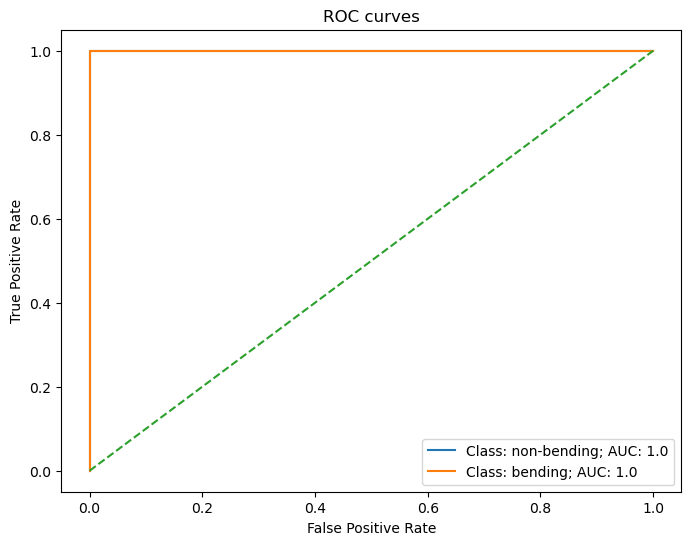

ROC Curve for Test Data


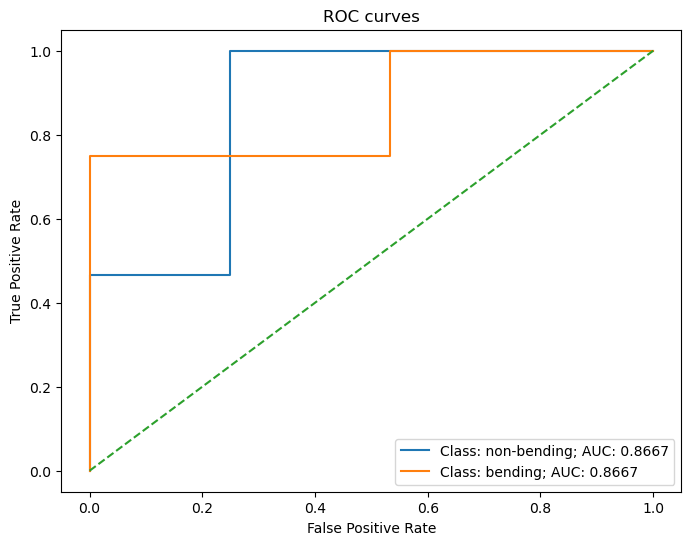

In [96]:
print("Best model with split = {}, max_test_accuracy = {}\n".format(best_split, max_test_accuracy))
logistic_regression_classification(data_train_mapping, test_data_map, best_split, is_plot_roc = True, is_binary = True, features = selected_features)

 Multi-class Classification (The Realistic Case)


In [97]:
selected_features = ['mean', '50%', 'std']
cv_fold, split_range, result = 5, 20, []
max_test_accuracy, best_split = 0, 1

for split in range(1, split_range + 1):
    result.append(logistic_regression_classification(data_train_mapping, test_data_map, split, cv_fold = cv_fold, features = selected_features))
    if result[-1][1] > max_test_accuracy:
        max_test_accuracy = result[-1][1]
        best_split = split

result = pd.DataFrame(result, columns = ['L', 'Train Score', 'Train Error'])
result

,L,Train Score,Train Error
0,1,0.871429,0.1286
1,2,0.871429,0.1286
2,3,0.827473,0.1725
3,4,0.812088,0.1879
4,5,0.754945,0.2451
5,6,0.754945,0.2451
6,7,0.754945,0.2451
7,8,0.710989,0.2890
8,9,0.739560,0.2604
9,10,0.725275,0.2747


Best model with split = 1, max_test_accuracy = 0.8714285714285717

Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


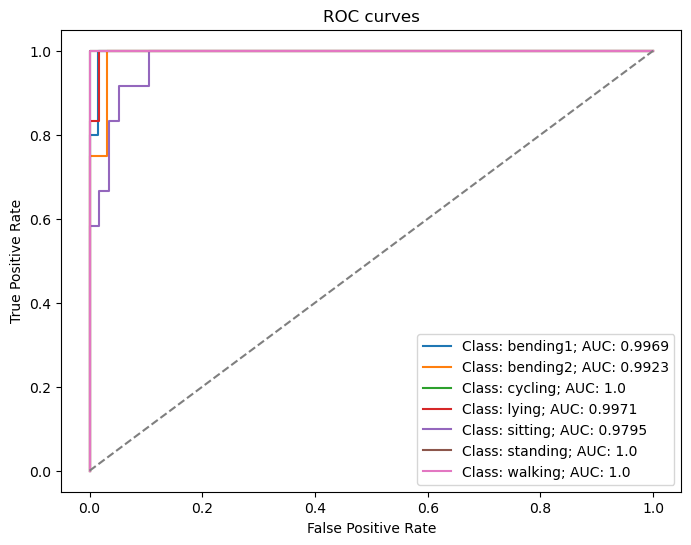

ROC Curve for Test Data


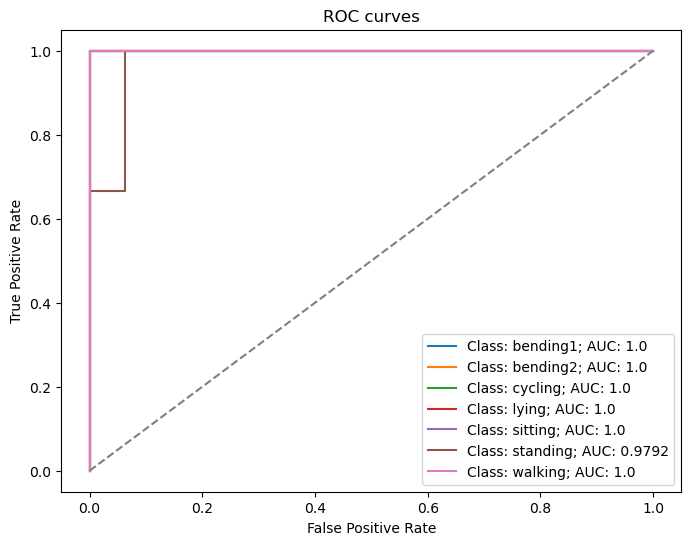

In [98]:
print("Best model with split = {}, max_test_accuracy = {}\n".format(best_split, max_test_accuracy))
logistic_regression_classification(data_train_mapping, test_data_map, best_split, is_plot_roc = True, features = selected_features)

 Naive Bayes

In [99]:
split_range, result = 20, []
max_test_accuracy, best_split = 0, 1

for split in range(1, split_range + 1):
    result.append(logistic_regression_classification(data_train_mapping, test_data_map, split, is_gaussian = True, features = selected_features))
    if result[-1][1] > max_test_accuracy:
        max_test_accuracy = result[-1][1]
        best_split = split

result = pd.DataFrame(result, columns = ['L', 'Train Score', 'Train Error'])
result

,L,Train Score,Train Error
0,1,0.870330,0.1297
1,2,0.797802,0.2022
2,3,0.768132,0.2319
3,4,0.770330,0.2297
4,5,0.753846,0.2462
5,6,0.681319,0.3187
6,7,0.710989,0.2890
7,8,0.724176,0.2758
8,9,0.709890,0.2901
9,10,0.767033,0.2330


Best model with split = 1, max_test_accuracy = 0.8703296703296705

Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


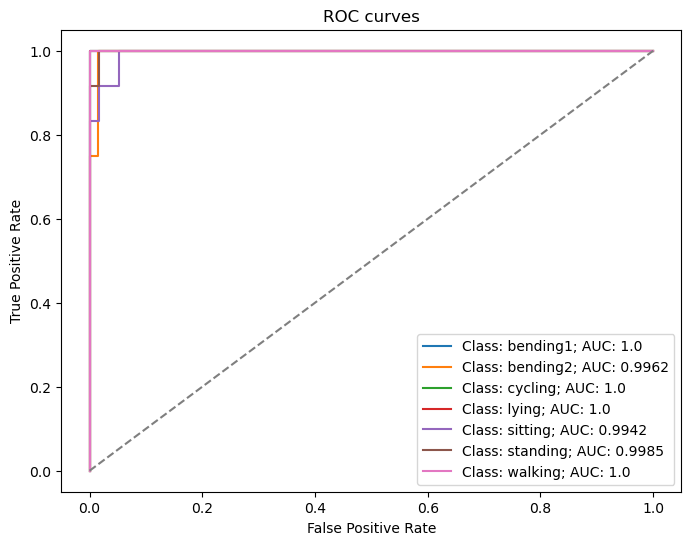

ROC Curve for Test Data


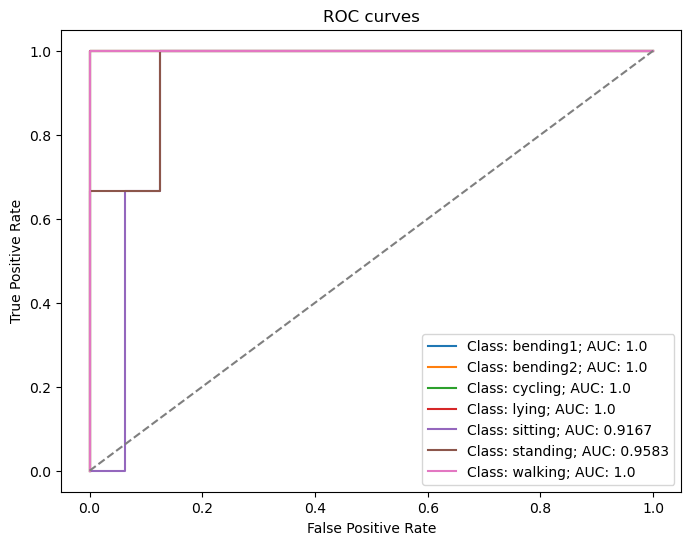

In [100]:
print("Best model with split = {}, max_test_accuracy = {}\n".format(best_split, max_test_accuracy))
logistic_regression_classification(data_train_mapping, test_data_map, best_split, is_gaussian = True, is_plot_roc = True, features = selected_features)

In [101]:
split_range, result = 20, []
max_test_accuracy, best_split = 0, 1

for split in range(1, split_range + 1):
    result.append(logistic_regression_classification(data_train_mapping, test_data_map, split, is_multinomial_prior = True, features = selected_features))
    if result[-1][1] > max_test_accuracy:
        max_test_accuracy = result[-1][1]
        best_split = split

result = pd.DataFrame(result, columns = ['L', 'Train Score', 'Train Error'])
result

,L,Train Score,Train Error
0,1,0.825275,0.1747
1,2,0.826374,0.1736
2,3,0.812088,0.1879
3,4,0.827473,0.1725
4,5,0.840659,0.1593
5,6,0.797802,0.2022
6,7,0.783516,0.2165
7,8,0.783516,0.2165
8,9,0.769231,0.2308
9,10,0.769231,0.2308


Best model with split = 5, max_test_accuracy = 0.8406593406593406

Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


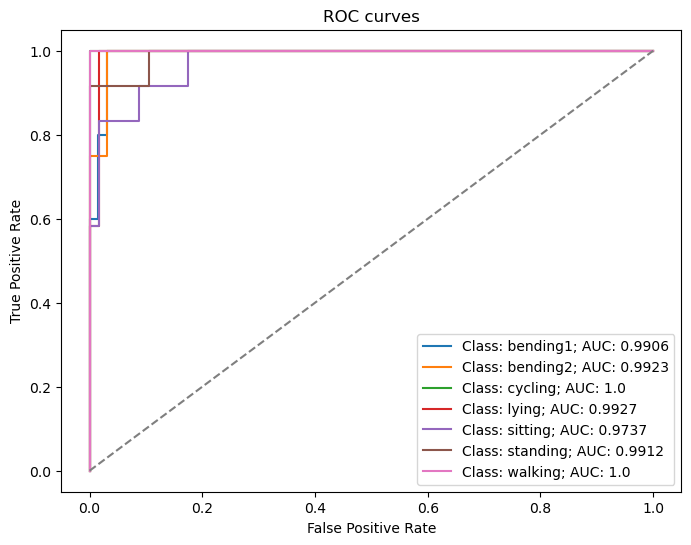

ROC Curve for Test Data


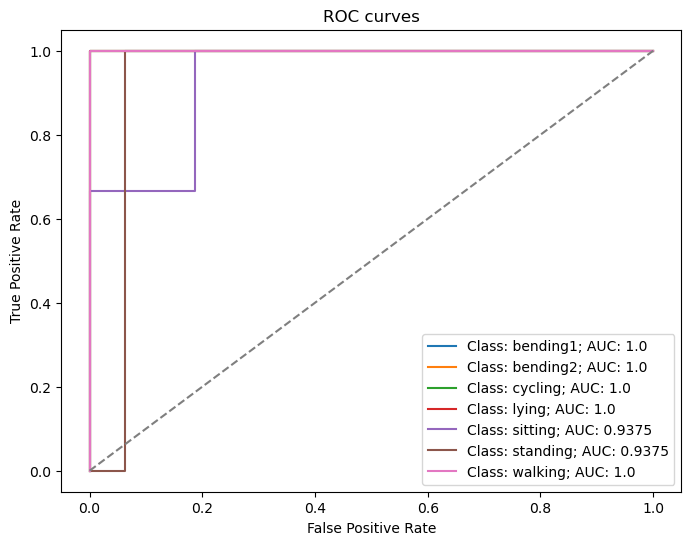

In [102]:
print("Best model with split = {}, max_test_accuracy = {}\n".format(best_split, max_test_accuracy))
logistic_regression_classification(data_train_mapping, test_data_map, best_split, is_multinomial_prior = True, is_plot_roc = True, features = selected_features)

Comparision

* Within the Naive Bayes’ classifier the Gaussian prior (~0.87 accuracy) performs better as compared to the Multinomial prior (~0.84 accuracy).


#### Best result

* The area under the ROC curve (AUC) is relatively better for the Multinomial Regression curve than any other classifier prior (Gaussian or Multinomial) and hence, I would say that Multinomial Regression has better classification for the given dataset.


There are two classes of response value. Here we can use Bayes’ therorem:

$$Pr(Y=Yes|X=x)=\frac{\pi_1 f_1(x)}{\sum_{l=1}^2\pi_l f_l(x)}$$

where $f_i(x) = \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{\frac{-1}{2\sigma_i^2}(x - \mu_i)^2}$ 

Here $\pi_1 = 0.8, \pi_2 = 0.2$, $f_1(x)$ is the density function of a normal random variable with mean $10$ and variance $36$ and $f_2(x)$ is the density function of a normal random variable with mean $0$ and variance $36$.

Pluggin all values to the above equation: 

$$Pr(Y=Yes|X=x) = \frac{0.8e^{\frac{-1}{2*36}(4 - 10)^2}}{0.8e^{\frac{-1}{2*36}(4 - 10)^2} + 0.2e^{\frac{-1}{2*36}(4 - 0)^2}}$$

$$Pr(Y=Yes|X=x) = 0.7519$$